In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG19,ResNet50V2, InceptionV3, InceptionResNetV2, ConvNeXtLarge, Xception
from skimage.metrics import structural_similarity as ssim
from numpy.linalg import norm
from google.colab.patches import cv2_imshow
from sklearn.neighbors import NearestNeighbors


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# Function to load images from a folder
def load_images(folder_path):
    images = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            images.append(img)
    return np.array(images)

In [3]:
folder_path = "/content/drive/MyDrive/PROJECT/DATA/data_ws"

In [4]:
images = load_images(folder_path)

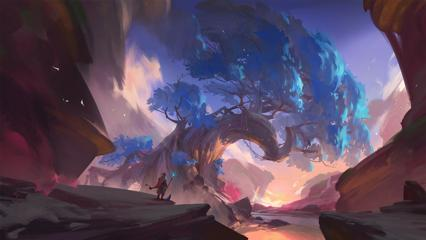

(240, 426, 3)


In [6]:
cv2_imshow(images[99])
print(images[34].shape)

# Extract features here :

In [ ]:
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
model_name = "VGG19"

# Extract features
features = vgg_model.predict(images)


print(features.shape)

38/38 [==============================] - 1574s 41s/step
(1209, 7, 13, 512)


In [ ]:
resnet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
model_name = "ResNet50V2"
features = resnet_model.predict(images)

print(features.shape)

38/38 [==============================] - 16s 239ms/step
(1209, 8, 14, 2048)


In [ ]:

model_name = "InceptionV3"
ince_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
features = ince_model.predict(images)

print(features.shape)

38/38 [==============================] - 15s 232ms/step
(1209, 2048)


In [ ]:

model_name = "InceptionResNetV2"
ince_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
features = ince_model.predict(images)

print(features.shape)

38/38 [==============================] - 24s 412ms/step
(1209, 6, 11, 1536)


In [ ]:

model_name = "ConvNeXtLarge"
ince_model = ConvNeXtLarge(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
features = ince_model.predict(images)

print(features.shape)

38/38 [==============================] - 89s 2s/step
(1209, 7, 13, 1536)


In [ ]:
model_name = "Xception"
ince_model = Xception(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
features = ince_model.predict(images)

print(features.shape)

38/38 [==============================] - 20s 357ms/step
(1209, 8, 14, 2048)


# Visualize the clustering in 2D

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


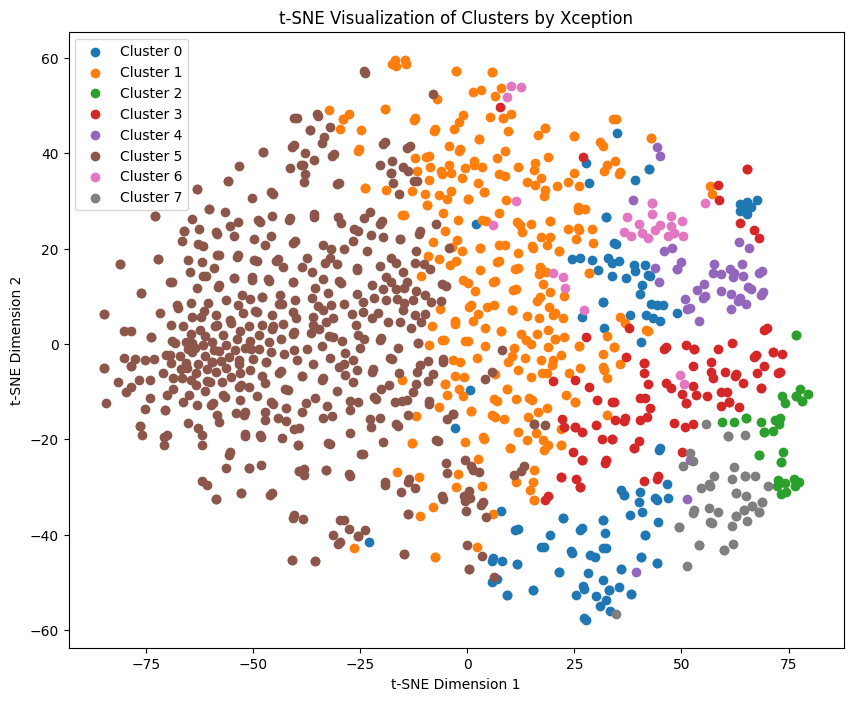

In [ ]:
X = features.reshape(features.shape[0], -1)

# Perform KMeans clustering
num_clusters = 8  # You can adjust this based on your preference
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(X)

# Perform dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X)

# Visualize the clustering
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    plt.scatter(tsne_results[cluster_labels == i, 0], tsne_results[cluster_labels == i, 1], label=f'Cluster {i}')
plt.title(f't-SNE Visualization of Clusters by {model_name}')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

In [ ]:

# Fit KNN model
knn = NearestNeighbors(n_neighbors=num_clusters, metric='euclidean')
knn.fit(X)

# Define a function to find similar images
def find_similar_images(image_index):
    distances, indices = knn.kneighbors([X[image_index]], n_neighbors=11)
    print(indices)

    # Find the index of the query image within the list of indices
    query_image_index = np.where(indices[0] == image_index)[0][0]

    # Remove the query image itself by index
    similar_images_indices = np.delete(indices[0], query_image_index)
    similar_images_distances = np.delete(distances[0], query_image_index)

    return similar_images_indices, similar_images_distances
# Function to plot images using indices
def compute_cosine_similarity(image1, image2):

    # Convert images to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Flatten images into 1D arrays
    vector1 = gray_image1.flatten().astype(float)
    vector2 = gray_image2.flatten().astype(float)

    # Compute cosine similarity
    cosine_similarity = np.dot(vector1, vector2) / (norm(vector1) * norm(vector2))

    return cosine_similarity

def histogram_intersection(image1, image2):
    # Convert images to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Compute histograms
    hist1 = cv2.calcHist([gray_image1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([gray_image2], [0], None, [256], [0, 256])

    # Normalize histograms
    hist1 /= np.sum(hist1)
    hist2 /= np.sum(hist2)

    # Compute Histogram Intersection similarity
    intersection_similarity = np.sum(np.minimum(hist1, hist2))

    return intersection_similarity


def compute_ssim(image1, image2):
    # Convert images to grayscale
    gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Compute SSIM
    similarity_index = ssim(gray_image1, gray_image2)

    return similarity_index

def plot_images(image_index, similar_images_indices, similarity_distances):
    original_image = images[image_index]


    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(f'{model_name} model', fontsize=20)
    # Plot original image
    plt.subplot(3, 5, 1)
    plt.imshow(original_image[:, :, ::-1])
    plt.title(f'Original Image\nws_{image_index}.jpg')
    plt.axis('off')

    # Plot similar images
    for i, idx in enumerate(similar_images_indices):
        similar_image = images[idx]
        cossim = compute_cosine_similarity(original_image,similar_image)
        ssim = compute_ssim(original_image,similar_image)
        hist = histogram_intersection(original_image,similar_image)
        plt.subplot(3, 5, i + 6)
        plt.imshow(similar_image[:, :, ::-1])
        plt.title(f'Cosine similarity: {cossim*100:.2f}%\nStructural similarity: {ssim*100:.2f}%\nHistogram similarity: {hist*100:.2f}%\nws_{idx}.jpg')
        plt.axis('off')

    plt.tight_layout()
    plt.show()




[[155  25 302 138 988 300  72 241  76 100 299]]


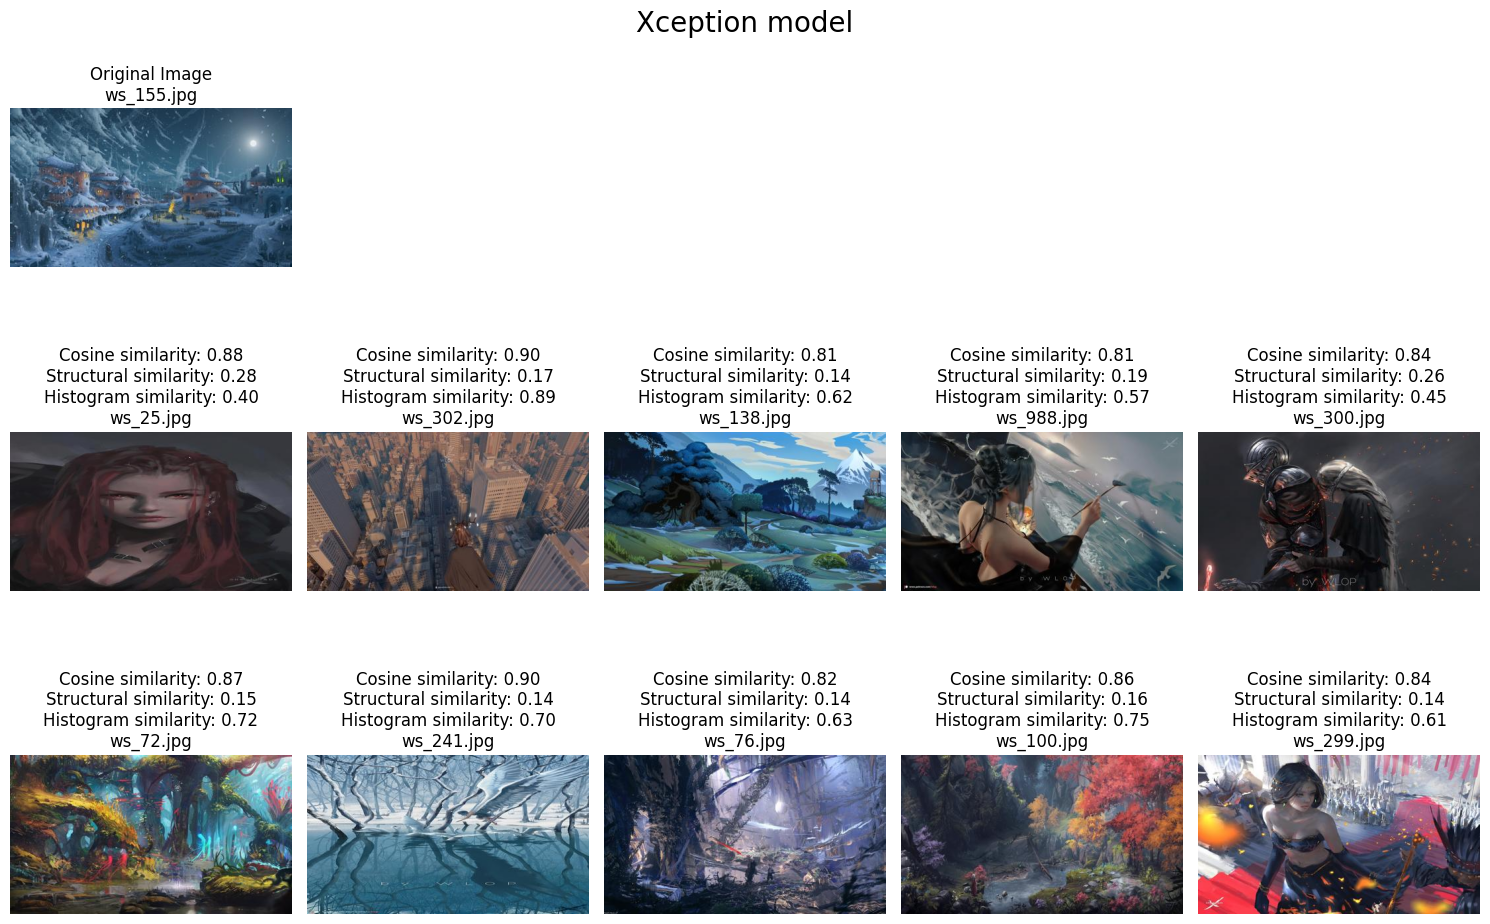

In [ ]:
# Example usage
image_index = 155

similar_images_indices, similar_images_distances = find_similar_images(image_index)

# Plot images using indices
plot_images(image_index, similar_images_indices, similar_images_distances)

In [ ]:
np.random.seed(42)


test_idx = np.random.randint(0, len(images), size=120)
print(test_idx)

[1126  860 1130 1095 1044  121  466  330   87 1123  871  130  769  343
  805  385  955  276 1184  459   21  252  747  856  474 1082  510  699
  975  189  957  686  957  562  831 1154  646   20  840  166  387  600
  315   13  241  776  564  897   91  955  508  775   34  205 1104 1025
 1021  565 1129  702  401  729  161  201  995  269  815  455 1016  295
  719  337  878 1076  791  216  763  187  379  492 1064 1180   14   64
  520 1152  647 1086 1162  592  391  418  288  378  230 1017   40 1051
  134  200  779  929 1056 1071  502  406  804   98  683  725  960  612
  642 1028  502  766  397  870  794  392]


In [ ]:
avg_cosine_similarity = []
avg_histogram_intersection = []
avg_ssim = []

for i in test_idx:
  original_image = images[i];
  similar_images_indices, _ = find_similar_images(image_index)
  for idx in similar_images_indices:
        similar_image = images[idx]
        avg_cosine_similarity.append(compute_cosine_similarity(original_image,similar_image))
        avg_ssim.append(compute_ssim(original_image,similar_image))
        avg_histogram_intersection.append(histogram_intersection(original_image,similar_image))

print(f"Using {model_name} :")
print(f"Average Cosine Similarity : {np.mean(avg_cosine_similarity)*100}%")
print(f"Average Structural Similarity : {np.mean(avg_ssim)*100}%")
print(f"Average Histogram Similarity : {np.mean(avg_histogram_intersection)*100}%")